In [1]:
# expand cells to the 95% of the display width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 95% !important; }</style>"))

# Tutorial: Automatic rule-based modeling of the *Escherichia coli* lactose metabolism, including protein-protein interactions and regulation of gene expression employing *Atlas*

Authors: Rodrigo Santibáñez[1,2], Daniel Garrido[2], and Alberto Martín[1]

Date: August 2020

Affiliations:
1. Centro de Genómica y Bioinformática, Facultad de Ciencias, Universidad Mayor, Santiago, 8580745, Chile.
2. Department of Chemical and Bioprocess Engineering, School of Engineering, Pontificia Universidad Católica de Chile, Santiago, 7820436, Chile

Notes: This tutorial was created for the manuscript "*Atlas*: Automatic modeling of regulation of bacterial gene expression and metabolism using rule-based languages", first submitted for peer-review to Bioinformatics on May, 2020.

## Prerequisites

0. The tutorial was prepared and executed on Ubuntu 20.04, PathwayTools version 24, and docker engine version 19.03.8.<br/><br/>

1. PathwayTools must be installed and running to obtain data from the EcoCyc database. Please, run ```pathway-tools -lisp -python-local-only``` before to obtain any data.<br/>
   (Optional) The PathwayTools software could be executed in the background, with help of ```nohup pathway-tools -lisp -python-local-only > /dev/null 2> /dev/null &```.<br/>
   Please follow instructions at http://pathwaytools.org/ to obtain a licensed copy of the software from https://biocyc.org/download-bundle.shtml. However, data could be manually formatted using a text-based editor or a spreadsheet software.
   
   Note: If you ran into the ```pathway-tools/aic-export/pathway-tools/ptools/22.5/exe/aclssl.so: undefined symbol: CRYPTO_set_locking_callback``` error, please follow instructions here: https://github.com/glucksfall/atlas/tree/master/PTools. Instructions will guide you to install a docker image that is able to run pathway tools, but does not include it, so you still need to obtain the software with a valid license.<br/><br/>
   
2. (Highly recommended) Install Docker. Please follow instructions for a supported Operating System https://docs.docker.com/engine/install/:<br/>
   On Ubuntu, install it with ```apt-get install docker.io```.<br/>
   On Win10, install Docker Desktop with WSL2 support https://docs.docker.com/docker-for-windows/wsl/.<br/>
   On MacOS, install Docker Desktop https://docs.docker.com/docker-for-mac/install/.<br/><br/>
   The Docker ```networkbiolab/pleiades```installs the python packages, the jupyter server, and the stochastic simulators.<br/><br/>

3. (Recommended) Jupyter notebook. We recommend the use of Anaconda3 https://www.anaconda.com/products/individual because of the easier installation of the stochastic simulators from https://anaconda.org/alubbock.<br/><br/>

4. (Optional) A stochastic simulator, supported by the pySB python package ([BNG2](https://github.com/RuleWorld/bionetgen), [NFsim](https://github.com/ruleworld/nfsim/tree/9178d44455f6e27a81f398074eeaafb2a1a4b4bd), [KaSim](https://github.com/Kappa-Dev/KappaTools) or [Stochkit](https://github.com/StochSS/StochKit)). pySB requires BNG2 to simulate models with NFsim.<br/><br/>

5. (Optional) Cytoscape to visualize metabolic networks and others.

## Preamble: load *Atlas*

In [2]:
# testing source code
import sys
sys.path.append("../..") # If installed from GitHub and this notebooks is executed from the example/subfolder directory.

import atlas_rbm.atlas as atlas
import atlas_rbm.utils as utils
import atlas_rbm.export as export
import atlas_rbm.simulation as simulation

## Modeling transcription and translation

Here, we will model a representation of transcription and translation in addition to the activity of transcription factors. We employed the Kappa BioBrick Framework (KBF, https://core.ac.uk/download/pdf/82069591.pdf) and automated the modeling of rules describing bacterial transcription and translation. Especially in the case of mRNA, the synthesis and degradation of any mRNA is affected by the genome architecture. The transcription from the lactose operon is initiated at four promoters and terminated by two Rho-independent terminators. Moreover, we modeled an internal promoter that drives transcription from the lacYA operon, although its importance *in vivo* is not clear.

The following image (https://ecocyc.org/gene?orgid=ECOLI&id=EG10527#tab=TU) shows the organization of the three genes and the many promoters and terminators of the *Escherichia coli* lactose operons:

<img src="lactose-operon.png" alt="drawing"/>

**Note**: An operon is defined as the protomer-CDS-terminator unit. Therefor, we refer to the lactose *operon* as the organization of 10 overlapped operons.

In [3]:
%time model1 = atlas.construct_model_from_genome_graph('input_networks/network-lac-operon-arq.tsv', additionalProteins = ['lacI'])
# lacI operon is not modeled, but we required to add the protein into the Monomer list to make able to add the regulatory rule into the model
model1

CPU times: user 1.43 s, sys: 81.7 ms, total: 1.51 s
Wall time: 1.54 s


<Model 'atlas_rbm.construct_model_from_genome_graph' (monomers: 4, rules: 31, parameters: 53, expressions: 0, compartments: 0) at 0x7f7c1ffcaac0>

In [4]:
model1 = atlas.modify_rules(
    model1, 
    oldString = "prot(name='lacY', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=None)",
    newString = "prot(name='lacY', loc='imem', dna=None, met=None, prot=None, rna=None, up=None, dw=None)",
    names = ['sr_lacY_rbs'])

**Note**: *Atlas* creates rules for the synthesis of cytoplasmic proteins.

## Modeling regulation of gene expression

A model of the lactose metabolism is completed with a representation of transcriptional control. To model gene regulation, we extended the interaction network with LacI-DNA complexes. In the case of LacI, each dimer binds in tandem to one operator sequence, and two dimers could dimerize, forming a DNA loop that impedes to the RNAP-$\sigma$ bind the promoters or initiates transcription.

In [5]:
utils.read_network('input_networks/network-lac-TFs+DNA.tsv')

,SOURCE,TARGET,FWD_RATE,RVS_RATE,LOCATION
0,"[lacI,lacI]",BS-lacI-422-402,1.0,0.01,cytosol
1,"[lacI,lacI]",BS-lacI-21-1,1.0,0.01,cytosol
2,"[lacI,lacI]",BS-lacI-72-92,1.0,0.01,cytosol


However, the incorporation of interactions between a transcription factor and its DNA binding site is not enough. We must carefully modify the rules that model gene expression to consider the presence or absence of the complex as condition for gene synthesis. In the case of LacI, the promoters must be free to be able to bind the RNAP-$\sigma$ and activate transcription:

In [6]:
model1 = atlas.add_regulation(model1, name = 'docking_lacZ_pro1', conditions = ['[lacI,lacI,BS-lacI-21-1]'], replace = False, verbose = True)

model1 = atlas.add_regulation(model1, name = 'docking_lacZ_pro1', conditions = ['BS-lacI-21-1'], replace = True, verbose = True)
model1 = simulation.set_parameter(model1, 'fwd_docking_lacZ_pro1_regulated_by_lacI', 1) # the add_regulation() set the rule parameters equal to zero
model1 = simulation.set_parameter(model1, 'rvs_docking_lacZ_pro1_regulated_by_lacI', 1)
model1

Rule('docking_lacZ_pro1_regulated_by_lacI_1', 
	prot(name = 'lacI', loc = 'cyt', dna = None, met = None, up = None, dw = 1) %
	prot(name = 'lacI', loc = 'cyt', dna = 2, met = None, up = 1, dw = None) %
	dna(name = 'lacI_21_1', type = 'BS', loc = 'cyt', prot = 2, up = WILD, dw = WILD) +
	cplx(name='RNAP_CPLX', loc='cyt', dna=None) + dna(name='lacZ', type='pro1', loc='cyt', prot=None) |
	prot(name = 'lacI', loc = 'cyt', dna = None, met = None, up = None, dw = 1) %
	prot(name = 'lacI', loc = 'cyt', dna = 2, met = None, up = 1, dw = None) %
	dna(name = 'lacI_21_1', type = 'BS', loc = 'cyt', prot = 2, up = WILD, dw = WILD) +
	cplx(name='RNAP_CPLX', loc='cyt', dna=3) % dna(name='lacZ', type='pro1', loc='cyt', prot=3), 
	Parameter('fwd_docking_lacZ_pro1_regulated_by_lacI_1', 0), 
	Parameter('rvs_docking_lacZ_pro1_regulated_by_lacI_1', 0))
Rule('docking_lacZ_pro1_regulated_by_lacI_2', 
	dna(name = 'lacI_21_1', type = 'BS', loc = 'cyt', prot = None, up = WILD, dw = WILD) +
	cplx(name='RNAP_CPLX

<Model 'atlas_rbm.construct_model_from_genome_graph' (monomers: 4, rules: 32, parameters: 57, expressions: 0, compartments: 0) at 0x7f7c1ffcaac0>

**Note**: To activate transcription, the `lacI-21-1` binding site must be free. Also, we must delete the expression rule because it could be triggered even in the situation the binding site is occupied.

To inactivate LacI, free proteins bind allolactose that seems to impede the binding of LacI-allolactose complexes to DNA binding sites:

In [7]:
utils.read_network('input_networks/network-lac-ProtMet-nobinding.tsv')

,SOURCE,TARGET,FWD_RATE,RVS_RATE,LOCATION
0,"[lacI,lacI]",SMALL-alpha-ALLOLACTOSE,0,0,cytosol
1,"[lacI,lacI,SMALL-alpha-ALLOLACTOSE]",SMALL-alpha-ALLOLACTOSE,0,0,cytosol
2,"[lacI,lacI]",SMALL-beta-ALLOLACTOSE,0,0,cytosol
3,"[lacI,lacI,SMALL-beta-ALLOLACTOSE]",SMALL-beta-ALLOLACTOSE,0,0,cytosol


Because *Atlas* enumerates the physical interactions, we must concatenate the networks prior its modeling:

In [8]:
import pandas
%time network = pandas.concat([utils.read_network('input_networks/network-lac-ProtProt.tsv'), \
                               utils.read_network('input_networks/network-lac-TFs+DNA.tsv'), \
                               utils.read_network('input_networks/network-lac-ProtMet-nobinding.tsv')])
network.reset_index(drop = True) # reset_index() is optional; Also, you could use a spreadsheet software or text editor to copy and paste data into a single file.

CPU times: user 15.4 ms, sys: 0 ns, total: 15.4 ms
Wall time: 15.7 ms


,SOURCE,TARGET,FWD_RATE,RVS_RATE,LOCATION
0,lacZ,lacZ,1.0,0.00,cytosol
1,"[lacZ,lacZ]","[lacZ,lacZ]",1.0,0.00,cytosol
2,lacA,lacA,1.0,0.00,cytosol
3,lacA,"[lacA,lacA]",1.0,0.00,cytosol
4,lacI,lacI,1.0,0.00,cytosol
5,"[lacI,lacI]",BS-lacI-422-402,1.0,0.01,cytosol
6,"[lacI,lacI]",BS-lacI-21-1,1.0,0.01,cytosol
7,"[lacI,lacI]",BS-lacI-72-92,1.0,0.01,cytosol
8,"[lacI,lacI]",SMALL-alpha-ALLOLACTOSE,0.0,0.00,cytosol
9,"[lacI,lacI,SMALL-alpha-ALLOLACTOSE]",SMALL-alpha-ALLOLACTOSE,0.0,0.00,cytosol


**Note**: *Atlas* interprets an interaction network as a protein-protein interaction network. To define metabolites, please prefix names with `SMALL-` and DNA binding sites as `BS-` followed by a name and two coordinates.

In [9]:
%time model2 = atlas.construct_model_from_interaction_network(network)
model2

CPU times: user 849 ms, sys: 0 ns, total: 849 ms
Wall time: 872 ms


<Model 'atlas_rbm.construct_model_from_interaction_network' (monomers: 3, rules: 12, parameters: 38, expressions: 0, compartments: 0) at 0x7f7c1ffca430>

In [10]:
new_rule = "Rule('PhysicalInteractionRule_02', "\
            "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=2) % "\
            "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=2, dw=None) + "\
            "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=1) % "\
            "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=None) | "\
            "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=4, dw=1) % "\
            "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=2) % "\
            "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=2, dw=3) % "\
            "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=3, dw=4), "\
            "fwd_PhysicalInteractionRule_02, rvs_PhysicalInteractionRule_02)"

model2 = atlas.replace_rule(model2, 'PhysicalInteractionRule_02', new_rule)

In [11]:
new_rule = "Rule('PhysicalInteractionRule_04', "\
            "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=None) + "\
            "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=1) % "\
            "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=None) | "\
            "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=3, dw=1) % "\
            "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=2) % "\
            "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=2, dw=3), "\
            "fwd_PhysicalInteractionRule_04, rvs_PhysicalInteractionRule_04)"

model2 = atlas.replace_rule(model2, 'PhysicalInteractionRule_04', new_rule)

Finally, we build the metabolic network:

In [12]:
%time model3 = atlas.construct_model_from_metabolic_network('input_networks/network-lac-metabolism-complex-new-parameters.tsv')
model3

CPU times: user 1.23 s, sys: 3.66 ms, total: 1.23 s
Wall time: 1.28 s


<Model 'atlas_rbm.construct_model_from_metabolic_network' (monomers: 2, rules: 18, parameters: 61, expressions: 0, compartments: 0) at 0x7f7bd015f880>

In [13]:
model3 = atlas.modify_rules(
    model3, 
    oldString = "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=1) % " \
                "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=2) % " \
                "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=2, dw=3) % " \
                "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up=3, dw=None)",
    
    newString = "prot(name='lacZ', loc='cyt', dna=None, met=None, prot=None, rna=None, up = ANY, dw = ANY)",
    names = [
        'BETAGALACTOSID_RXN',
        'BETAGALACTOSID_RXN_alpha', 
        'RXN0_5363', 
        'RXN0_5363_beta', 
        'ALLOLACTOSE_DEG_alpha', 
        'ALLOLACTOSE_DEG_beta', 
        'RXN_17726', 
        'RXN0_7219'])

In [14]:
model3 = atlas.modify_rules(
    model3, 
    oldString = "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=1) % " \
                "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=2) % " \
                "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up=2, dw=None)",
    
    newString = "prot(name='lacA', loc='cyt', dna=None, met=None, prot=None, rna=None, up = ANY, dw = ANY)",
    names = ['GALACTOACETYLTRAN_RXN_galactose'])

In [15]:
%time combined = atlas.combine_models([model1, model2, model3])
combined

CPU times: user 5.79 s, sys: 39.1 ms, total: 5.83 s
Wall time: 6.3 s


<Model 'atlas_rbm.atlas' (monomers: 5, rules: 62, parameters: 147, expressions: 0, compartments: 0) at 0x7f7bd006d190>

In [16]:
# initial condition
# for metabolites (set again doesn't hurt)
simulation.set_initial.met(combined, 'beta_lactose', 'per', 100)
simulation.set_initial.met(combined, 'PROTON', 'per', 100) # required for lactose transport
simulation.set_initial.met(combined, 'WATER', 'cyt', 100) # required for lactose hydrolysis

# for proteins. We set to zero to simulate gene expression as a requisite for metabolic activity
simulation.set_initial.prot(combined, 'lacY', 'imem', 0)
simulation.set_initial.prot(combined, 'lacZ', 'cyt', 0)
simulation.set_initial.prot(combined, 'lacA', 'cyt', 0)

# except lacI
simulation.set_initial.prot(combined, 'lacI', 'cyt', 20)

# for complexes. We set to zero to simulate complex assembly as a requisite for metabolic activity
simulation.set_initial.cplx(combined, 'lacAx3', 'cyt', 0) # the codename for complexes is the monomer names times the stoichiometry
simulation.set_initial.cplx(combined, 'lacZx4', 'cyt', 0)
simulation.set_initial.cplx(combined, 'RNAP_CPLX', 'cyt', 5)
simulation.set_initial.cplx(combined, 'RIBOSOME_CPLX', 'cyt', 1)

# and DNA
simulation.set_initial.dna(combined, 'lacZlacYlacA', 1)

# simulation
bng = '/opt/git-repositories/bionetgen.RuleWorld/bng2/'
kasim = '/opt/git-repositories/KaSim4.Kappa-Dev/'

# %time data1 = simulation.scipy(combined, start = 0, finish = 10, points = 500) # +15h calculating the ODEs...
%time data2 = simulation.kasim(combined, start = 0, finish = 10000, points = 1000, n_runs = 100, path = kasim)

Initial t0_met_beta_lactose_per not found. Creating Initial t0_met_beta_lactose_per...
Initial t0_met_PROTON_per not found. Creating Initial t0_met_PROTON_per...
Initial t0_prot_lacY_imem not found. Creating Initial t0_prot_lacY_imem...
Initial t0_cplx_RNAP_CPLX_cyt not found. Creating Initial t0_cplx_RNAP_CPLX_cyt...
Initial t0_cplx_RIBOSOME_CPLX_cyt not found. Creating Initial t0_cplx_RIBOSOME_CPLX_cyt...
CPU times: user 6.74 s, sys: 1.05 s, total: 7.78 s
Wall time: 5min 56s


In [17]:
print(len(combined.rules))
print(len(combined.initials))
print(len(combined.monomers))
print(len(combined.observables))

62
49
5
48


In [18]:
import seaborn
import matplotlib.pyplot as plt

for key in [
#     'figure.titlesize',
    'font.size',
#     'legend.fontsize',
#     'legend.title_fontsize',
    'font.size', 
#     'xtick.labelsize',
    'xtick.major.size',
    'xtick.minor.size',
#     'ytick.labelsize',
    'ytick.major.size',
    'ytick.minor.size']:
    plt.rcParams[key] = plt.rcParams[key] * 1.1

palette = seaborn.color_palette('colorblind')

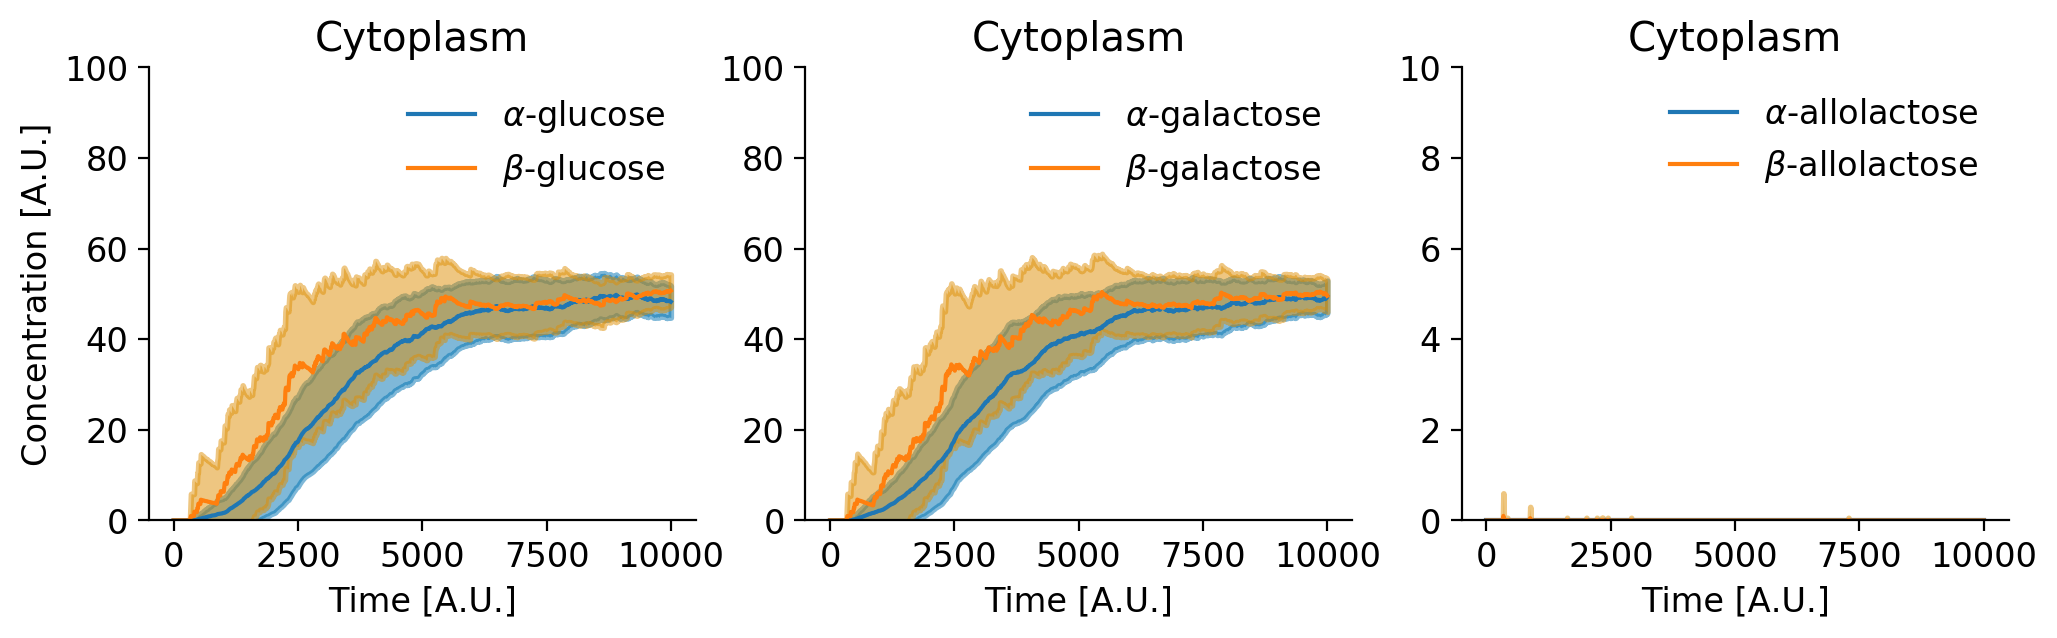

In [19]:
kind = 'fill_between'
fig, ax = plt.subplots(1, 3, figsize = (4*3, 3*1), dpi = 200)

# first plot, lactose concentration
simulation.plot.metabolite(data2['avrg'], 'alpha-glucose', 'cyt', ax = ax[0], plt_kws = {'label' : r'$\alpha$-glucose'})
simulation.plot.metabolite(data2['avrg'], 'beta-glucose', 'cyt', ax = ax[0], plt_kws = {'label' : r'$\beta$-glucose'})

simulation.plot.metabolite(
    data2, 'alpha-glucose', 'cyt', ax = ax[0], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[0], 'alpha' : .5})

simulation.plot.metabolite(
    data2, 'beta-glucose', 'cyt', ax = ax[0], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[1], 'alpha' : .5})

# second plot, galactose concentration
simulation.plot.metabolite(data2['avrg'], 'alpha-GALACTOSE', 'cyt', ax = ax[1], plt_kws = {'label' : r'$\alpha$-galactose'})
simulation.plot.metabolite(data2['avrg'], 'beta-GALACTOSE', 'cyt', ax = ax[1], plt_kws = {'label' : r'$\beta$-galactose'})

simulation.plot.metabolite(
    data2, 'alpha-GALACTOSE', 'cyt', ax = ax[1], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[0], 'alpha' : .5})

simulation.plot.metabolite(
    data2, 'beta-GALACTOSE', 'cyt', ax = ax[1], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[1], 'alpha' : .5})

# third plot, allolactose concentration
simulation.plot.metabolite(data2['avrg'], 'alpha-ALLOLACTOSE', 'cyt', ax = ax[2], plt_kws = {'label' : r'$\alpha$-allolactose'})
simulation.plot.metabolite(data2['avrg'], 'beta-ALLOLACTOSE', 'cyt', ax = ax[2], plt_kws = {'label' : r'$\beta$-allolactose'})

simulation.plot.metabolite(
    data2, 'alpha-ALLOLACTOSE', 'cyt', ax = ax[2], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[0], 'alpha' : .5})

simulation.plot.metabolite(
    data2, 'beta-ALLOLACTOSE', 'cyt', ax = ax[2], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[1], 'alpha' : .5})

ax[0].set_xlabel('Time [A.U.]')
ax[0].set_ylabel('Concentration [A.U.]')
ax[0].set_title('Cytoplasm')
ax[0].set_ylim(top = 100, bottom = 0)

ax[1].set_xlabel('Time [A.U.]')
ax[1].set_title('Cytoplasm')
ax[1].set_ylim(top = 100, bottom = 0)

ax[2].set_xlabel('Time [A.U.]')
ax[2].set_title('Cytoplasm')
ax[2].set_ylim(top = 10, bottom = 0)

ax[0].legend(frameon = False)
ax[1].legend(frameon = False)
ax[2].legend(frameon = False)

seaborn.despine()
plt.savefig('figure_1D.pdf', format = 'pdf', bbox_inches = 'tight', dpi = 300)
plt.savefig('figure_1D.png', format = 'png', bbox_inches = 'tight', dpi = 300)
plt.savefig('figure_1D.jpg', format = 'jpg', bbox_inches = 'tight', dpi = 300)

plt.show()

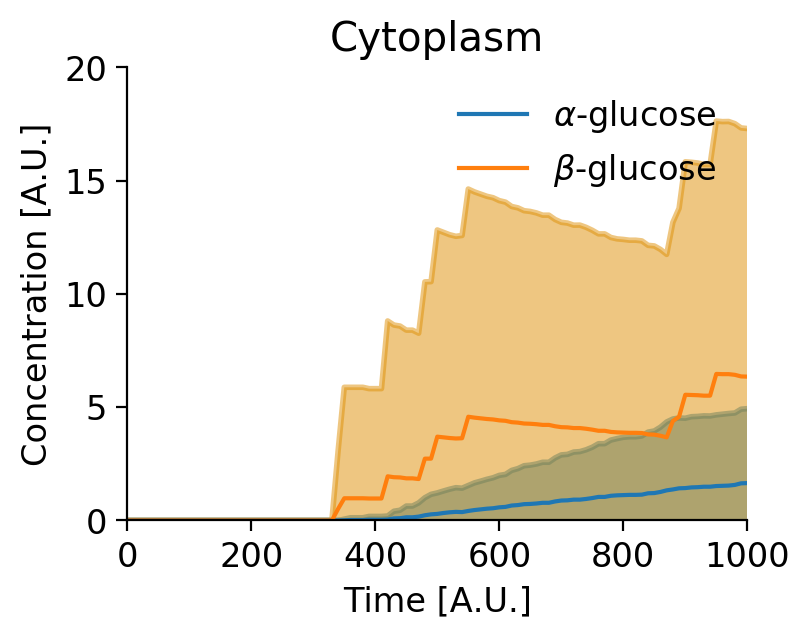

In [20]:
kind = 'fill_between'
fig, ax = plt.subplots(1, 1, figsize = (4*1, 3*1), dpi = 200)

# first plot, lactose concentration
simulation.plot.metabolite(data2['avrg'], 'alpha-glucose', 'cyt', ax = ax, plt_kws = {'label' : r'$\alpha$-glucose'})
simulation.plot.metabolite(data2['avrg'], 'beta-glucose', 'cyt', ax = ax, plt_kws = {'label' : r'$\beta$-glucose'})

simulation.plot.metabolite(
    data2, 'alpha-glucose', 'cyt', ax = ax, **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette, 'alpha' : .5})

simulation.plot.metabolite(
    data2, 'beta-glucose', 'cyt', ax = ax, **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[1], 'alpha' : .5})

ax.set_xlabel('Time [A.U.]')
ax.set_ylabel('Concentration [A.U.]')
ax.set_title('Cytoplasm')
ax.set_ylim(top = 20, bottom = 0)
ax.set_xlim(left = 0, right = 1000)
ax.legend(frameon = False)

seaborn.despine()
plt.savefig('figure_1D_inset.pdf', format = 'pdf', bbox_inches = 'tight', dpi = 300)
plt.savefig('figure_1D_inset.png', format = 'png', bbox_inches = 'tight', dpi = 300)
plt.savefig('figure_1D_inset.jpg', format = 'jpg', bbox_inches = 'tight', dpi = 300)

plt.show()